In [2]:
import gymnasium as gym
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

# set seeds
seed = 42
torch.manual_seed(seed)
random.seed(seed)

In [3]:
env = gym.make('LunarLander-v3')
env.action_space.seed(seed)

# print some information
print('Action space:', env.action_space)
print('Observation space:', env.observation_space)
print('Max episode steps:', env.spec.max_episode_steps)

Action space: Discrete(4)
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Max episode steps: 1000


### Set up network

In [ ]:
class PG(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=-1)   

In [ ]:
from pg import train_pg, train_pg_lunar_lander

# Hyperparams
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
gamma = 0.99

lr = 1e-3
batch_size = 1
n_episodes = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
policy_net = PG(input_dim, output_dim).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=lr)
# value_net = ValueNetwork(input_dim).to(device)
# value_optimizer = optim.Adam(value_net.parameters(), lr=1e-3)

In [ ]:
policy_net, all_rewards, all_losses = train_pg(
                                        policy_net,
                                        optimizer,
                                        env,
                                        n_episodes,
                                        gamma,
                                        batch_size=batch_size,
                                        save_every=None,
                                        save_path=None,
                                        temporal=False,  # Make this true if you want to exploit the temporal structure
                                        advantage=False,
                                        solved=(200, 100),
                                    )

## The advantage normalization method we used for CartPole didn't work so hot here.
## Instead, we use a constant advantage normalization (b = average returns over trajectories)
# policy_net, all_rewards, all_losses = train_pg_lunar_lander(
#                                         policy_net,
#                                         optimizer,
#                                         env,
#                                         n_episodes,
#                                         gamma,
#                                         batch_size=8,
#                                         save_every=None,
#                                         save_path=None,
#                                         temporal=True,
#                                         advantage=True,
#                                         solved=(200, 100),
#                                     )

Training:   0%|          | 0/10000 [00:00<?, ?it/s]/DATA/charchit.sharma/py_irt_lib_test/test_rahul/playground/rl/pg.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  advantages_tensor = torch.tensor(advantages, dtype=torch.float32, device=device)
Episode 10000/10000 | Reward: -73.98330949073876, Loss: 37398.07466796875:   0%|          | 0/10000 [2:16:55<?, ?it/s] 


In [8]:
# Save all_rewards to a file
import pickle
with open('rewards_base_lunarlander.pkl', 'wb') as f:
    pickle.dump(all_rewards, f)

In [12]:
# Load from pickle files
file_1 = 'rewards_base_lunarlander.pkl'
file_2 = 'rewards_temporal_lunarlander.pkl'
file_3 = 'rewards_advantage_lunarlander.pkl'

rewards_1, rewards_2, rewards_3 = None, None, None

with open(file_1, 'rb') as f:
    rewards_1 = pickle.load(f)
with open(file_2, 'rb') as f:
    rewards_2 = pickle.load(f)
with open(file_3, 'rb') as f:
    rewards_3 = pickle.load(f)
    
longest_len = max(len(rewards_1), len(rewards_2), len(rewards_3))

# make all the files the same length, by appending the last value
rewards_1 += [rewards_1[-1]] * (longest_len - len(rewards_1))
rewards_2 += [rewards_2[-1]] * (longest_len - len(rewards_2))
rewards_3 += [rewards_3[-1]] * (longest_len - len(rewards_3))

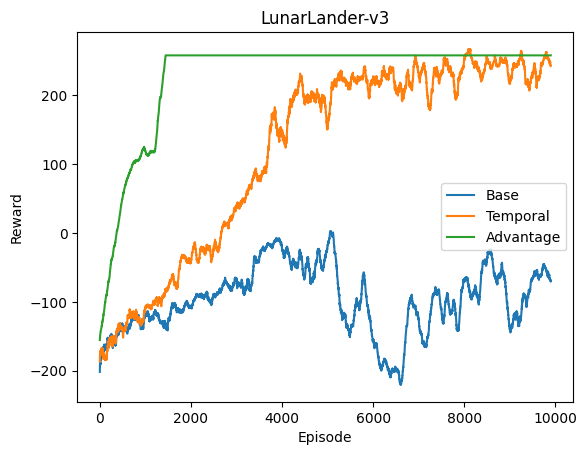

In [16]:
import matplotlib.pyplot as plt

rolling_average_window = 100
avg_1 = [sum(rewards_1[i:i+rolling_average_window])/rolling_average_window for i in range(len(rewards_1) - rolling_average_window)]
avg_2 = [sum(rewards_2[i:i+rolling_average_window])/rolling_average_window for i in range(len(rewards_2) - rolling_average_window)]
avg_3 = [sum(rewards_3[i:i+rolling_average_window])/rolling_average_window for i in range(len(rewards_3) - rolling_average_window)]

plt.plot(avg_1, label='Base')
plt.plot(avg_2, label='Temporal')
plt.plot(avg_3, label='Advantage')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('LunarLander-v3')
plt.legend()

It is also interesting to note in the figure above, that the plots are much smoother for temporal/advantage than the abse curve (change the rolling window size to see this more clearly)

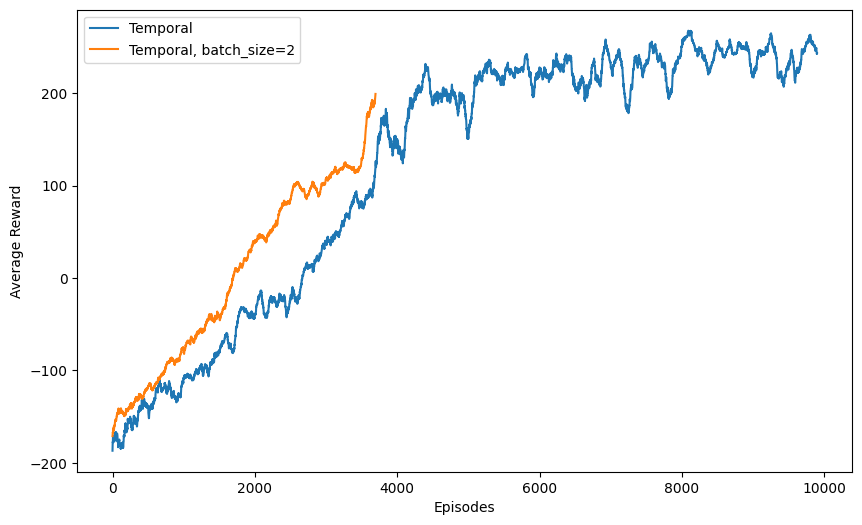

In [13]:
rewards_b2 = None
with open('rewards_temporal_b2_lunarlander.pkl', 'rb') as f:  # This is the file for the temporal method with b=2
    rewards_b2 = pickle.load(f)
    
import matplotlib.pyplot as plt

rolling_average_window = 100
plt.figure(figsize=(10, 6))
avg_2 = [sum(rewards_2[i:i+rolling_average_window])/rolling_average_window for i in range(len(rewards_2) - rolling_average_window)]
avg_b2 = [sum(rewards_b2[i:i+rolling_average_window])/rolling_average_window for i in range(len(rewards_b2) - rolling_average_window)]

plt.plot(avg_2, label='Temporal')
plt.plot(avg_b2, label='Temporal, batch_size=2')

plt.xlabel('Episodes')
plt.ylabel('Average Reward')

plt.legend()
plt.show()

Just like in the CartPole environment, a higher batch size results in the environment being solved in less epochs. (Note that early stopping was used for the algorithm with batch size 2, when it reached avg_reward of 200.0)